# TD3

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

In [2]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import pickle
import gc
import json
import h5py

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

# comment out if you are not using themes
from jupyterthemes import jtplot
jtplot.style(theme='grade3')

# == recnn ==
import sys
sys.path.append("../../")
import recnn

cuda = torch.device('cuda')
# ---
frame_size = 10
batch_size = 25
# --- 

tqdm.pandas()

In [3]:
# https://drive.google.com/open?id=1kTyu05ZmtP2MA33J5hWdX8OyUYEDW4iI
movie_embeddings_key_dict = pickle.load(open('../../data/infos_pca128.pytorch', 'rb'))
movies_embeddings_tensor, \
key_to_id, id_to_key = recnn.data.make_items_tensor(movie_embeddings_key_dict)
# download ml20m dataset yourself
ratings = pd.read_csv('../../data/ml-20m/ratings.csv')
user_dict, users = recnn.data.prepare_dataset(ratings, key_to_id, frame_size)
del ratings
gc.collect()
clear_output(True)
clear_output(True)
print('Done!')

Done!


In [4]:
def soft_update(net, target_net, soft_tau=1e-2):
    for target_param, param in zip(target_net.parameters(), net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )
            
def run_tests():
    test_batch = next(iter(test_dataloader))
    losses = td3_update(step, test_batch, params, learn=False)
    return losses

In [5]:
def td3_update(step, batch, params, learn=True):
    
    batch = [i.to(cuda) for i in batch]
    state, action, reward, next_state, done = batch
    
    # --------------------------------------------------------#
    # Value Learning
    
    reward     = reward.unsqueeze(1)
    done       = done.unsqueeze(1)
    
    next_action = target_policy_net(next_state)
    noise = torch.normal(torch.zeros(next_action.size()),
                         params['noise_std']).to(cuda)
    noise = torch.clamp(noise, -params['noise_clip'], params['noise_clip'])
    next_action += noise
    
    with torch.no_grad():
        target_q_value1  = target_value_net1(next_state, next_action)
        target_q_value2  = target_value_net2(next_state, next_action)
        target_q_value   = torch.min(target_q_value1, target_q_value2)
        expected_q_value = reward + (1.0 - done) * params['gamma'] * target_q_value
    
    q_value1 = value_net1(state, action)
    q_value2 = value_net2(state, action)

    value_loss1 = value_criterion(q_value1, expected_q_value.detach())
    value_loss2 = value_criterion(q_value2, expected_q_value.detach())
    
    debugger.log_error('value1', q_value1)
    debugger.log_error('value2', q_value2)
    debugger.log_error('next_action', next_action)
    debugger.log_error('target_value ', target_q_value)
    
    if learn:
        value_optimizer1.zero_grad()
        value_loss1.backward()
        value_optimizer1.step()

        value_optimizer2.zero_grad()
        value_loss2.backward()
        value_optimizer2.step()

    # --------------------------------------------------------#
    # Policy learning

    gen_action = policy_net(state)
    policy_loss = value_net1(state, gen_action)
    policy_loss = -policy_loss.mean()
    
    if learn:
        debugger.log_object('gen_action', gen_action,  "mat")
        
    else: 
        debugger.log_object('test gen_action', gen_action, "mat")
        
    # delayed policy update
    if step % params['policy_update'] == 0 and learn:
        policy_optimizer.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(policy_net.parameters(), -1, 1)
        policy_optimizer.step()

        soft_update(value_net1, target_value_net1, soft_tau=params['soft_tau'])
        soft_update(value_net2, target_value_net2, soft_tau=params['soft_tau'])
    
    losses = {'value1': value_loss1.item(),
              'value2': value_loss2.item(),
              'policy': policy_loss.item(),
              'step'  : step}
    return losses

In [6]:
# === TD3 settings ===
params = {
    'gamma': 0.99,
    'noise_std': 0.1,
    'noise_clip': 0.3,
    'soft_tau': 0.1,
    'policy_lr': 1e-5,
    'value_lr': 1e-5,
    'policy_update': 30
}
# === end ===

In [7]:
value_net1  = recnn.models.Critic(1290, 128, 256).to(cuda)
value_net2 = recnn.models.Critic(1290, 128, 256).to(cuda)
policy_net = recnn.models.Actor(1290, 128, 256).to(cuda)

target_value_net1 = recnn.models.Critic(1290, 128, 256).to(cuda)
target_value_net2 = recnn.models.Critic(1290, 128, 256).to(cuda)
target_policy_net = recnn.models.Actor(1290, 128, 256).to(cuda)

nets =[value_net1, value_net2, policy_net]

soft_update(value_net1, target_value_net1, soft_tau=1.0)
soft_update(value_net2, target_value_net2, soft_tau=1.0)
soft_update(policy_net, target_policy_net, soft_tau=1.0)


value_criterion = nn.MSELoss()

value_optimizer1 = optim.Adam(value_net1.parameters(), lr=params['value_lr'])
value_optimizer2 = optim.Adam(value_net2.parameters(), lr=params['value_lr'])
policy_optimizer = optim.Adam(policy_net.parameters(), lr=params['policy_lr'])


layout = {
    'train': {'value1': [], 'value2': [], 'policy': [], 'step': []},
    'test': {'value1': [], 'value2': [], 'policy': [], 'step': []}
    }

debugger = recnn.Debugger(layout, run_tests)
plotter = recnn.Plotter(debugger, [['value1', 'policy']],)

In [8]:
step = 1
n_epochs = 100
batch_size = 25

epoch_bar = tqdm(total=n_epochs)

test_losses = [[], [], [], []]
train_users = users[:-5000]
test_users = users[-5000:]

def prepare_batch_wrapper(x):
    batch = recnn.data.prepare_batch_static_size(x, movies_embeddings_tensor, frame_size=frame_size)
    return batch

train_user_dataset = recnn.data.UserDataset(train_users, user_dict)
test_user_dataset = recnn.data.UserDataset(test_users, user_dict)
train_dataloader = DataLoader(train_user_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=1,collate_fn=prepare_batch_wrapper)
test_dataloader = DataLoader(test_user_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=1,collate_fn=prepare_batch_wrapper)

step 420


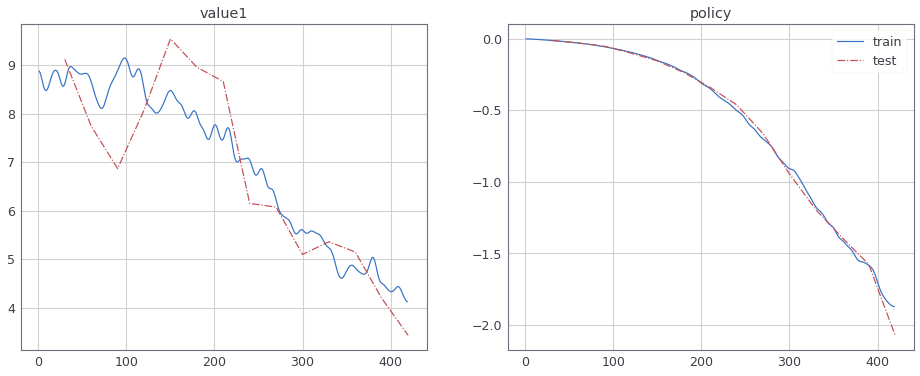

KeyboardInterrupt: 

In [9]:
# --- config ---
plot_every = 30
# --- end ---

for epoch in range(n_epochs):
    epoch_bar.update(1)
    for batch in tqdm(train_dataloader):
        loss = td3_update(step, batch, params)
        debugger.log_losses(loss)
        step += 1
        debugger.log_step(step)
        if step % plot_every == 0:
            clear_output(True)
            print('step', step)
            debugger.test()
            plotter.plot_loss()

In [17]:
#torch.save(value_net1.state_dict(), "../../models/td3_value_1.pt")
#torch.save(policy_net.state_dict(), "../../models/td3_policy_1.pt")

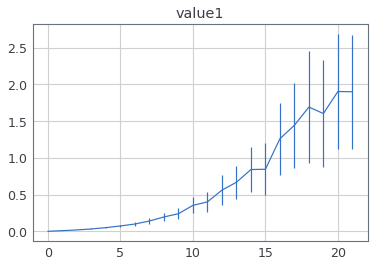

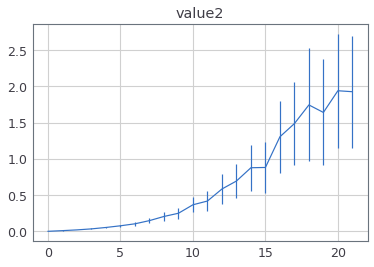

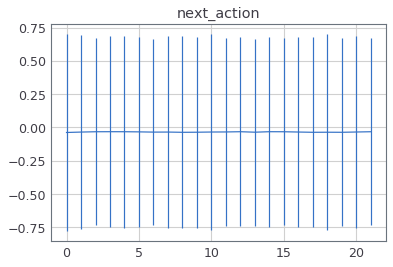

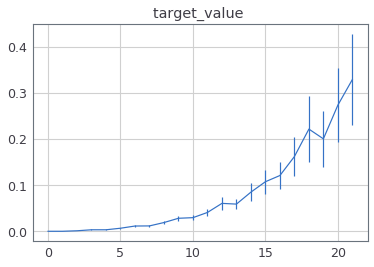

In [10]:
debugger.err_plot()

/home/dev/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


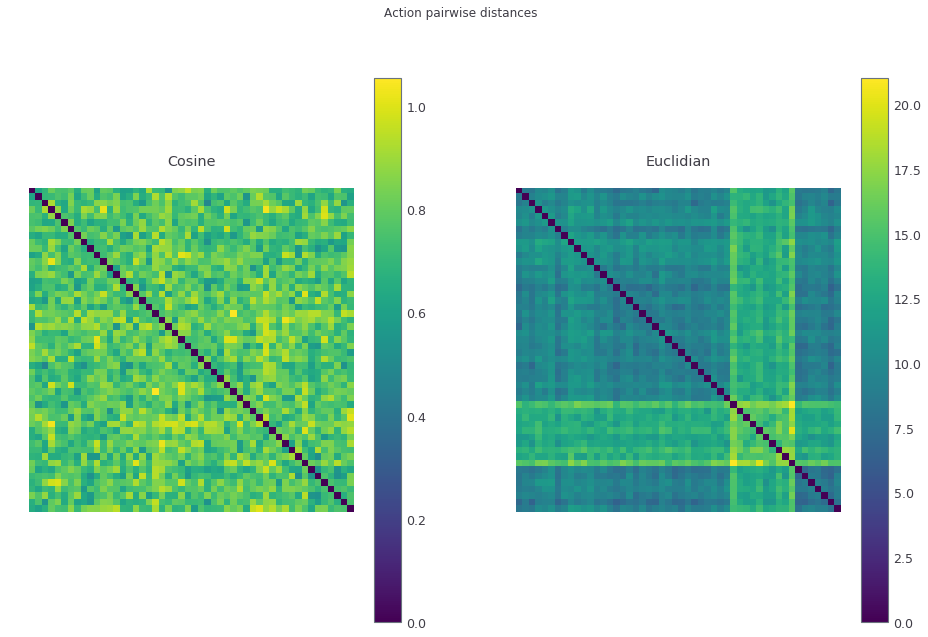

In [11]:
debugger.matshow('gen_action')

/home/dev/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


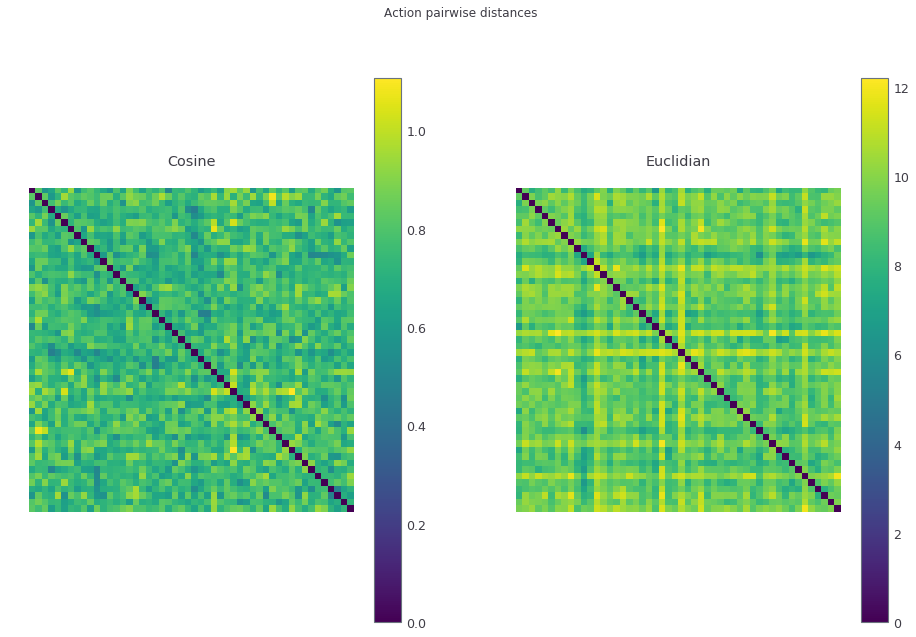

In [12]:
debugger.matshow('test gen_action')

In [13]:
gen_actions = debugger.debug_dict['obj']['gen_action']
gen_test_actions = debugger.debug_dict['obj']['test gen_action']
true_actions = np.stack(movie_embeddings_key_dict.values())
    
ad = recnn.models.AnomalyDetector().to(cuda)
ad.load_state_dict(torch.load('../../models/anomaly.pt'))
ad.eval()

debugger.plot_kde_reconstruction_error(ad, gen_actions, gen_test_actions, true_actions, cuda)

KeyError: 'gen_action'